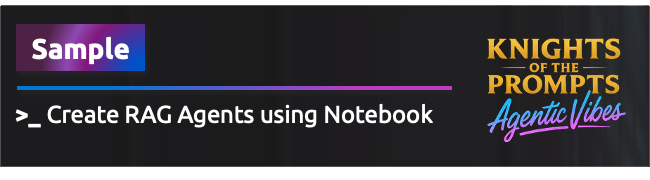
# Lab: Create RAG Agent using a Jupyter Notebook

In this lab, you will learn how to build a retrieval-augmented generation (RAG) agent using the Azure AI Agent Service SDK. You’ll connect your agent to Azure AI Search—a vector database containing health insurance policy documents—and configure it to retrieve relevant information in response to user queries. This hands-on exercise will guide you through connecting resources, creating a search index, vectorizing documents, and building an agent capable of intelligent document search. By the end of this lab, you’ll understand the RAG pattern and how to implement it with Azure AI services for real-world scenarios.

#### Part 1: Connect to you Azure AI Search service

NOTE: If you are working in a project team with 2 or more members, only one person needs to perform Part 1. Once configured, the AI Search connection will be available to everyone in the project to use. For learning purposes, you can screenshare this part of the setup to your project team.

Navigate to your Azure AI Foundry project > Management Center > Select 'connected resources' under your project and add your Azure AI Search service using 'Entra ID' authetication.

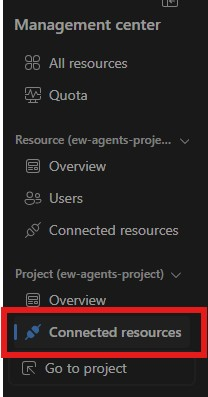

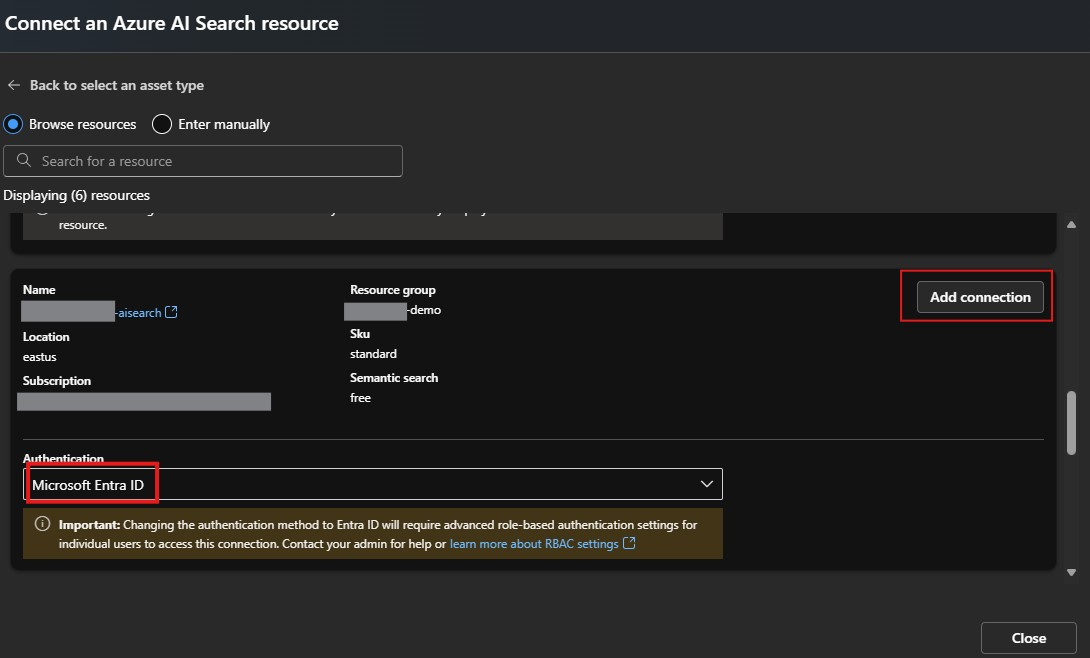

### Part 2: Create the Azure AI Search Index

We'll start the lab by creating an Azure AI Search index in our search service, which will contain vectorized representations of our health insurance plan documents. The steps shown below to create the AI Search index are from the official Microsoft [documentation](https://learn.microsoft.com/en-us/azure/search/search-get-started-portal-import-vectors?tabs=sample-data-storage%2Cmodel-aoai%2Cconnect-data-storage)

#### Step 1
Inspect the documents in the 'data-labs4to5' folder, which are sourced from [here](https://github.com/luckypamula/azure-ai-agents-labs/tree/main/data). These will be stored in our Azure AI Search index.

#### Step 2
Next, we'll upload the health plan documents to Azure Blob Storage, which Azure AI search connects to.
1. Navigate to the Storage Account setup in Lab 1. 
2. Expand "Data Storage" in the side menu and click on "Containers". 
3. Create a new container named: [your-initials] + "healthplan" (Example: 'efwhealthplan'). If you are working in a project team, everyone will be working in the same Storage Account, so we want to make sure our Blob Storage Container names are unique!

    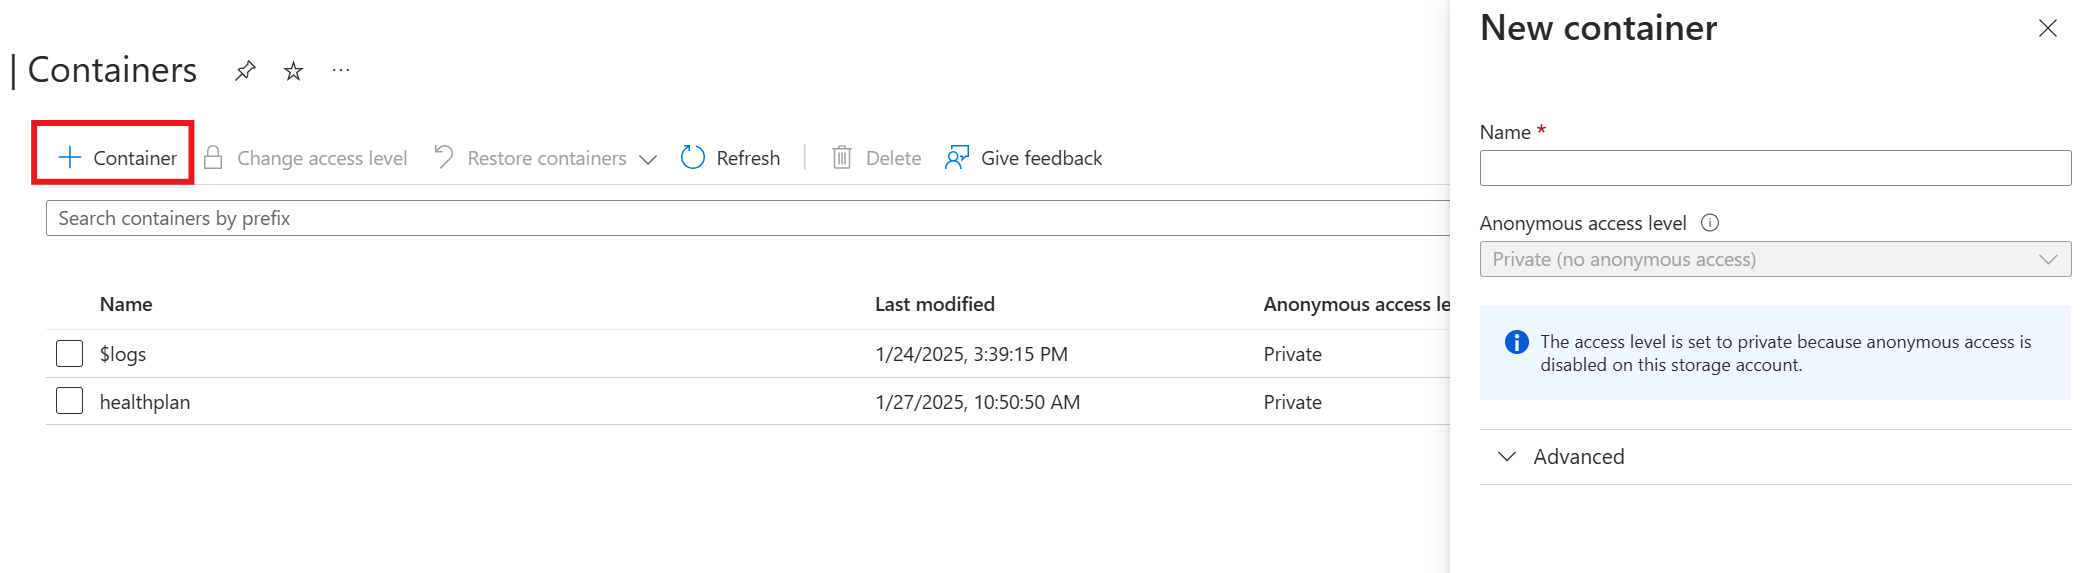
4. Click into the new container and upload the two documents in the 'data' folder.

    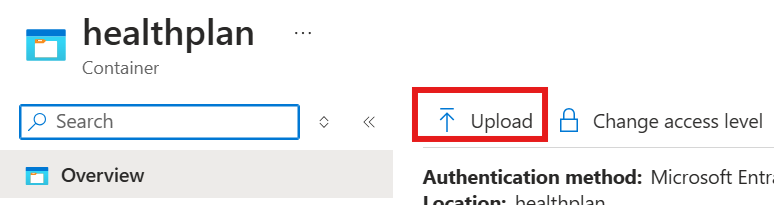

#### Step 3
We need an embedding model in order to convert our documents into vectors that will be stored in Azure AI Search...luckily, we've already deployed a text-embedding-3-large model in our Azure OpenAI service during the setup in Lab 1!

#### Step 4
Now we're ready to vectorize our documents.
1. Go to your Azure AI Search Service
2. On the **Overview page**, select **Import and vectorize data**.
3. Select **Azure Blob Storage** as your data source.
4. On the next page, select **RAG**.
5. On the next page **configure your Azure blob storage** by specifying your subscription, storage account, and the container that contains your healthplan documents 
6. Make sure **Authenticate using managed idenity is checked** and the **Managed identity type** is set to **System-assigned**.

    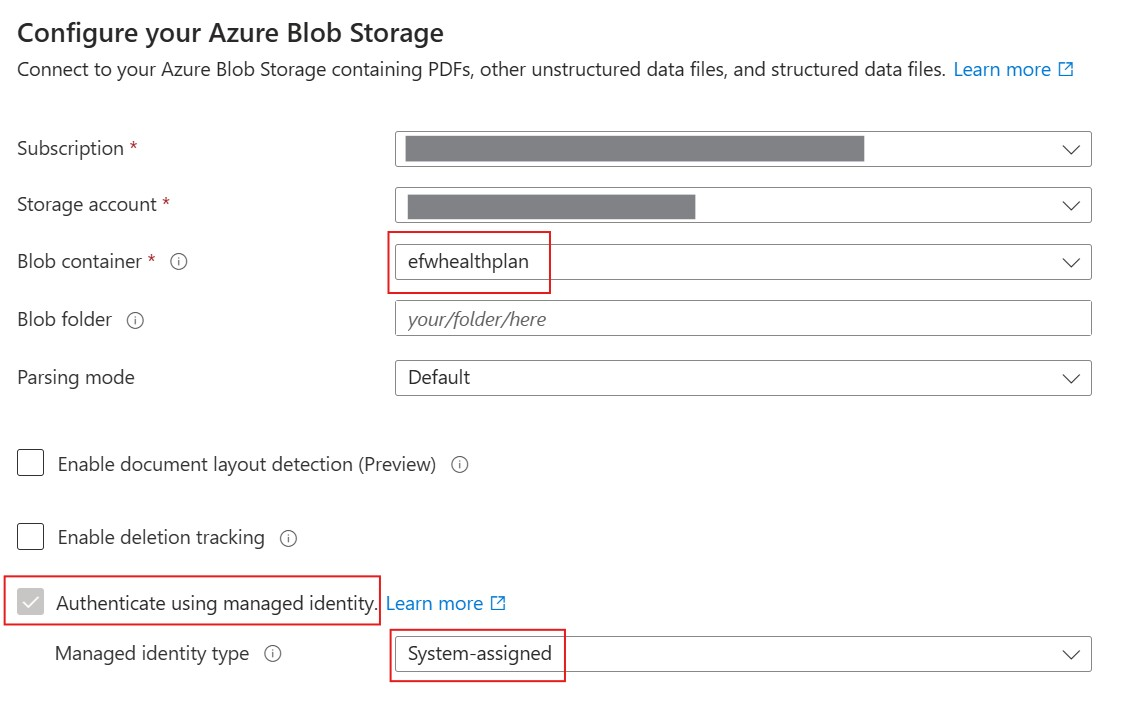

5. On the **Vectorize your text** page, select **Azure OpenAI** for **Kind**, select your subscription, and select the name of your Azure OpenAI Service.
6. For the **Model deployment** select `text-embedding-3-large`. 
7. The **Authentication type** should be set to **System-assigned identity**. 
8. Select the box next to the acknowledgement.

    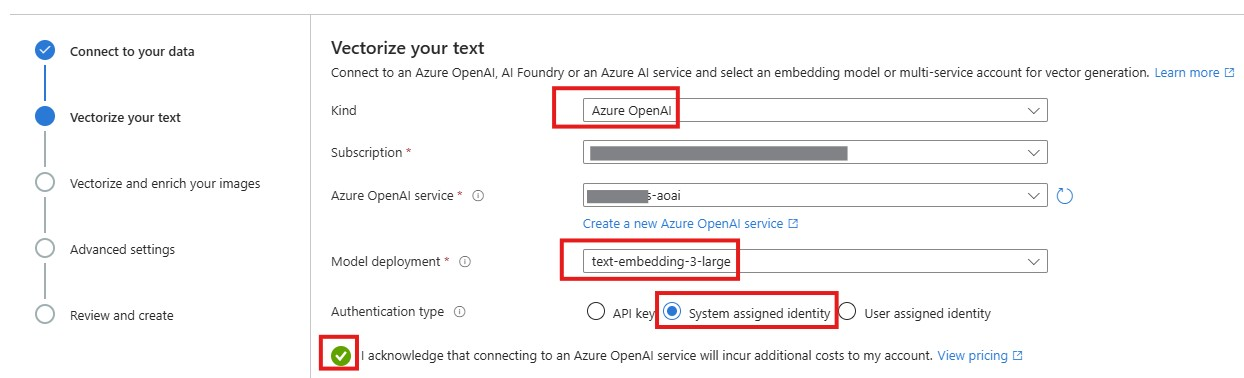

9. You can hit **Next** for the next two pages. When you get to the **Review and create** page, set **Objects name prefix** to **[your-blob-container-name]-index** (Example: 'efwhealthplan-index'). Click **Create**. This will start the document indexing process which will vectorize your documents and create an index. NOTE: it may take a few minutes for you index to fully populate with your document chunks. Wait until the process is complete BEFORE continuing to part 2.

    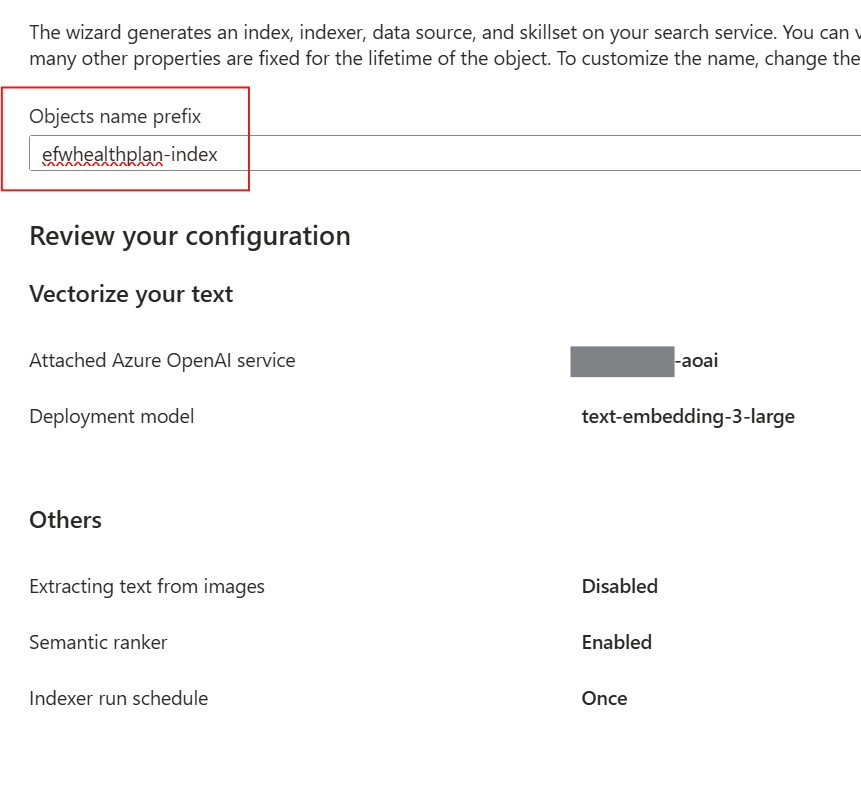

### Part 3: Create the Search Agent

Now that we've vectorized our health plan documents and created an index, we can build a Search Agent using the Azure AI Agent Service SDK. This agent will leverage the Azure AI Search index to retrieve relevant information from your health plan documents in response to user queries. In this section, you'll:
- Connect your code to the Azure AI Search index you created earlier
- Define and configure a search agent with the appropriate tools and resources
- Interact with the agent to perform intelligent, context-aware document retrieval

This hands-on exercise demonstrates how retrieval-augmented generation (RAG) can be implemented programmatically, enabling your agent to provide accurate, document-grounded answers using Azure AI services.

#### Step 1: Load packages

In [ ]:
import os
from dotenv import load_dotenv
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential
from azure.ai.agents.models import AzureAISearchToolDefinition, AzureAISearchToolResource, AISearchIndexResource, ToolResources, AgentThreadCreationOptions

load_dotenv()

#### Step 2: Connect to your Azure AI Foundry project

In [ ]:
# Connecting to our Azure AI Foundry project, which will allow us to use the deployed gpt-4o model
project = AIProjectClient(
    endpoint=os.getenv("AIPROJECT_ENDPOINT"),
    credential=DefaultAzureCredential()
)

#### Step 3: Connect to your Azure AI Search index

Make sure to update the below code cell with your index name

In [ ]:
# First enter the name of your search index

index_name="<my-index-name>"
print(index_name)

This code retrieves the connection ID for your Azure AI Search resource, then defines and configures the search tool and its resources. It ensures your agent is set up to access the correct search index, enabling it to perform document retrieval using the Azure AI Agent Service SDK.

In [ ]:
# Iterate through the connections in your project and get the connection ID of the Azure AI Search connection.
conn_id = None
for conn in project.connections.list():
    if getattr(conn, "type", None) == "CognitiveSearch":
        conn_id = conn.id
        break

if not conn_id:
    raise ValueError("No Azure Cognitive Search connection found in this project.")

# Define the Azure AI Search tool and its resources using the latest SDK classes, and connect to your AI Search index
ai_search_tool = AzureAISearchToolDefinition()
ai_search_resource = AzureAISearchToolResource(
    index_list=[
        AISearchIndexResource(
            index_connection_id=conn_id,
            index_name=index_name # Be sure to set your index name above
        )
    ]
)

# The tool resources are used to define the tools available to the agent
tool_resources = ToolResources(azure_ai_search=ai_search_resource)

#### Step 4: Define the search agent

In this step, you will define and create the search agent using the Azure AI Agent Service SDK. The agent is configured with the GPT-4o model, a descriptive name, instructions for its behavior, and the search tool and resources you set up previously. This setup enables the agent to process user queries and retrieve relevant information from your Azure AI Search index, making it capable of intelligent, document-grounded search.

In [ ]:
search_agent = project.agents.create_agent(
    model="gpt-4o",
    name="search-agent",
    instructions="You are a helpful agent that is an expert at searching health plan documents.",
    tools=[ai_search_tool],
    tool_resources=tool_resources
)

#### Step 5: Chat with the search agent

In this step, you'll interact with your search agent by sending it a user query and processing its response. The code demonstrates how to:
- Create a conversation thread with an initial user message
- Run the agent to process the query using the Azure AI Agent Service SDK
- Retrieve and display the agent's response, which is grounded in the indexed health plan documents
- Clean up by deleting the agent after use

This hands-on interaction shows how retrieval-augmented generation (RAG) enables your agent to provide accurate, document-based answers to natural language questions.

In [ ]:
# The name of the health plan we want to search for
plan_name = 'Northwind Standard'

# Create thread options with initial user message and tool resources (use dict for message)
thread_options = AgentThreadCreationOptions(
    messages=[
        {
            "role": "user",
            "content": f"Tell me about the {plan_name} plan."
        }
    ],
    tool_resources=tool_resources
)

# Use create_thread_and_process_run to create the thread, message, and run in one step
run = project.agents.create_thread_and_process_run(
    agent_id=search_agent.id,
    thread=thread_options
)

# Check if the run was successful
if run.status == "failed":
    print(f"Run failed: {run.last_error}")

# Delete the agent when it's done running
project.agents.delete_agent(search_agent.id)

# Fetch all the messages from the thread
messages = project.agents.messages.list(thread_id=run.thread_id)

# Print the last assistant/agent message's text, if any
last_msg = None
for msg in reversed(list(messages)):
    role = getattr(msg, "role", None)
    if role and ("agent" in role.lower() or "assistant" in role.lower()):
        last_msg = msg
        break

if last_msg and getattr(last_msg, "content", None) and isinstance(last_msg.content, list):
    for part in last_msg.content:
        if part.get("type") == "text" and "text" in part and "value" in part["text"]:
            print('Agent:', part["text"]["value"])
            break